In [29]:
#import Library
import cv2
import numpy as np
import pafy
import os
from functools import partial
print(cv2.__version__)
from multiprocessing.pool import Pool
import yt_dlp

4.8.1


In [ ]:
##########hand craft variance ananlysis#############
####1 comparatively static(not so much visual content)***** possible to filter out
####2 dynamic but irrelavent to the caption(most difficult)-object detection

#---------------------------------------------------------------------------------
#mean difference:
#1.take out frame in every 5 seconds(take one frame for every 125 frames)
#2.maxpool frames(pool size(2,2))
#3.calculate differences between every two neighboor frames(frame[2]-frame[1],frame[3]-frame[2].....)
#4.sum up all the differences and then divide the number of frames

###
#pros:
#1.It is fast
#### a 10 min video: 120 frames * 320 * 640(size after maxpool)=24576000
#2.It can filter out the videos that the frames visually change a little(people talking in the middle of screen all the time)
#cons:
#1. It will possibly filter out the video that may be useful for train
###if the action is at the corner of the screen or the behaviors changing slightly(when cuting the meat, the change between frames only the position of the knife which is thin and dosen't make a large difference between frames, large part of the image don't change a lot and it will gain a low score in this case



#Historgram Similarity/SSIM/MSE
#slow and computational costly


In [27]:
#convert into frame
def FrameCapture(path_url,frame):
    
    video = pafy.new(path_url)
    best = video.getbest(preftype="mp4")
    count = 0
    onum=0
    # Path to video file 
    vidObj = cv2.VideoCapture(best.url) 
    success = True
    
    success, image = vidObj.read() 
    while success: 
        # vidObj object calls read 
        # function extract frames
        success, image = vidObj.read()
       # grey_image= np.dot(image[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        if count%125==0:
            frame.append(image)
#             success, image = vidObj.read()
            onum+=1
        count+=1
    #print(onum, " frames extracted")
    frame = np.array(frame)
    #print("data shape =\t", frame.shape)
    return frame
    
    

In [3]:
good_path='https://www.youtube.com/watch?v=VVJxEengEt8'
bad_path='https://www.youtube.com/watch?v=O0U3soa2FY4'

In [6]:
frame1=[]
frame_good=FrameCapture(good_path,frame1)

In [7]:
frame2=[]
frame_bad=FrameCapture(bad_path,frame2)

onum

In [4]:
#maxpool
#1915/4
import torch
import torch.nn.functional as F
import numpy as np

# Sample RGB image as a TensorFlow tensor
def maxpool4(frame,size):
    # Convert the NumPy array to a PyTorch tensor
    image_tensor = torch.from_numpy(frame).permute(2, 0, 1).unsqueeze(0).float()

    # Define the pooling size (e.g., 2x2)
    pool_size = (size, size)

    # Perform max pooling
    pooled_image_tensor = F.max_pool2d(image_tensor, pool_size)

    # Convert the result back to a NumPy array for visualization
    pooled_image = pooled_image_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # The 'pooled_image' now contains the result of spatial max pooling
    #print(pooled_image)
    return pooled_image


In [ ]:
mp_image1=maxpool4(frame1[1],2)

In [5]:
#maxpool frames in an video(1/8 of all the frame)

def maxpool_allframeInvideo(frame_arr,size):
    maxpool_frameArr=[]
    for frame in frame_arr:
        pooled_frame=maxpool4(frame,size)
        maxpool_frameArr.append(pooled_frame)
    
    return maxpool_frameArr
        

In [12]:
pooled_frameArr=maxpool_allframeInvideo(frame1,2)

In [13]:
pooled_frameArr_bad=maxpool_allframeInvideo(frame2,2)

In [6]:
#deduction

def deduction(pooled_frameArr):
    deducted_arr=[]
    for i in range(len(pooled_frameArr)-1):
        deducted_frame=abs(pooled_frameArr[i+1]-pooled_frameArr[i])
        deducted_arr.append(deducted_frame)
    return deducted_arr
        

In [14]:
deducted_frames=deduction(pooled_frameArr)

In [15]:
deducted_frames_bad=deduction(pooled_frameArr_bad)

In [7]:
#variance ananlysis
### sum differences in all the deducted frame and divide the # of deducted frame
def addAlldifference_divideNumframe(deducted_frames):
    cursum=0
    AllSum=0
    meanDifference=0
    for frame in deducted_frames:
        cursum=sum(sum(sum(frame)))
        AllSum+=cursum
    meanDifference=AllSum/len(deducted_frames)
    return meanDifference

In [16]:
mean_diff=addAlldifference_divideNumframe(deducted_frames)
mean_diff

49617256.336065575

In [17]:
mean_diff_bad=addAlldifference_divideNumframe(deducted_frames_bad)
mean_diff_bad

9666187.60130719

In [18]:
mean_diff/mean_diff_bad

5.133074008345925

In [66]:
mean_diff/mean_diff_bad

5.062812763194205

In [ ]:
grey_mDiff=final('https://www.youtube.com/watch?v=VVJxEengEt8',2)
grey_mDiff

In [ ]:
grey_mDiff_bad=final('https://www.youtube.com/watch?v=O0U3soa2FY4',2)
grey_mDiff_bad

In [19]:
###integrate all the function into one
def final(path_url,size):
    original_frame=[]
    frames=FrameCapture(path_url,original_frame)
    pooled_frameArr=maxpool_allframeInvideo(frames,size)
    deducted_frames=deduction(pooled_frameArr)
    mean_diff=addAlldifference_divideNumframe(deducted_frames)
    return mean_diff
    

In [11]:
good=final('https://www.youtube.com/watch?v=VVJxEengEt8',2)
good

62  frames extracted
data shape =	 (62, 720, 1280, 3)


56332116.78688525

In [17]:
######  test  #########
v_list_move = [
    "i49TpqT2bps",
    "ibIYI4A_1PU",
    "nQRRtfv32Cs",
    "wdMEFFNou3Y",
    "jN1iAqW_SAY",
    "R2XlDqK6QYs",

	"Pp395_y5iAY",
	"XkPO0aGiwY8",
	"CiqD1W_xcs4",
    "Xn_7rwAHpPs",
    "8eBU4QfrFL4",
    "1-jnsbRQYCM",
    "V7xk-kgpZmk",
    "qB-E8q3yK4Q",
    "ke0YxzcZ1w4",
    "OGilPWdaikI",
    "9FSubSIXleo",
    "RHbDxf4EKb0",
    "jGuN68Z9rAY",
    "n1MIslYNju8",
    "McgjTFyCTfA",
    "qTPKGVrFtQU",
    "Q_EAYzJFt2g",
    "NM08R4kWcB8",
    "kMsWyPjRUZE",
    "IsS_d1FUJRU",
    "Ac533ZkHD5I",
    "ZNSwYGkDtNY",
    "6-GlYzwQkt8",
    
    
    
    
    
]

In [18]:
v_list_bad=["IJarJcOY8uU","LN9RYIR2GyA","ez7kowCEiSw","zhL4N9uXQO4","33te_Pqn9CY","Xz-6Is4FsP8"]
v_list_static=["IJarJcOY8uU","LN9RYIR2GyA","zhL4N9uXQO4","33te_Pqn9CY","O0U3soa2FY4","Hv0lzJZkfqU","XTaBAksP1d8","vFmSrHcm1_0","su7G18Flmpg","wzYeeEq_bpE","ABdevFdahy4","RBmeiMZQLsA","fEMqCktQEJo","H9jjNPfeWmA","8LX4earN0gY","obPT0w4LPow","pSlCKuSSdkA","nFMunlQ4ZrM","S1-xgIAVK4s","TtA4Txii0us","P5lDJYAsy_E","xbSp0TxZpM4","TtTsNNXrRU0","NQU7dxNJZEs","Vbia3YSI3pY"]


In [13]:
len(v_list_move)

25

In [16]:
len(v_list_static)

25

In [25]:
### concatinate the vid with website
def concate(vid):
    web_url='https://www.youtube.com/watch?v='+vid
    return web_url

In [21]:
### get all video mean difference

def get_allVideo_mean_differenceInlist(v_list):
    v_meanDiff_list=[]
    for v in v_list:
        url=concate(v)
        difference_mean=final(url,2)
        #print(v+":"+difference_mean)
        video_info = {
        "vid: ": v,
        "difference mean: ": difference_mean
        }
        v_meanDiff_list.append(video_info)
    return v_meanDiff_list

In [24]:
v_info=get_allVideo_mean_differenceInlist(v_list)

In [25]:
v_info

[{'vid: ': 'i49TpqT2bps', 'difference mean: ': 37507184.2992126},
 {'vid: ': 'ibIYI4A_1PU', 'difference mean: ': 28798096.516666666},
 {'vid: ': 'nQRRtfv32Cs', 'difference mean: ': 30344906.454545453},
 {'vid: ': 'wdMEFFNou3Y', 'difference mean: ': 40857938.244186044},
 {'vid: ': 'jN1iAqW_SAY', 'difference mean: ': 22698766.144144144},
 {'vid: ': 'R2XlDqK6QYs', 'difference mean: ': 16486677.852173913},
 {'vid: ': 'Pp395_y5iAY', 'difference mean: ': 7567390.678571428},
 {'vid: ': 'XkPO0aGiwY8', 'difference mean: ': 19182651.22047244},
 {'vid: ': 'CiqD1W_xcs4', 'difference mean: ': 35514837.282608695}]

In [30]:
v_info_bad=get_allVideo_mean_differenceInlist(v_list_bad)

In [31]:
v_info_bad

[{'vid: ': 'IJarJcOY8uU', 'difference mean: ': 27775114.38414634},
 {'vid: ': 'LN9RYIR2GyA', 'difference mean: ': 22125565.98924731},
 {'vid: ': 'ez7kowCEiSw', 'difference mean: ': 30910995.388349514},
 {'vid: ': 'zhL4N9uXQO4', 'difference mean: ': 12267539.783018868},
 {'vid: ': '33te_Pqn9CY', 'difference mean: ': 20204433.638095237},
 {'vid: ': 'Xz-6Is4FsP8', 'difference mean: ': 48168809.470198676}]

In [19]:
#####variance######
###Historgram-based
#two-similarity
import cv2
# Load images
def hist_similarity(image1,image2):
    #image1 = cv2.imread(image1)
    #image2 = cv2.imread(image2)
    hist_img1 = cv2.calcHist([image1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img1[255, 255, 255] = 0 #ignore all white pixels
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_img2 = cv2.calcHist([image2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img2[255, 255, 255] = 0  #ignore all white pixels
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # Find the metric value
    metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
    #print(f"Similarity Score: ", round(metric_val, 2))
    return metric_val

In [20]:
similarity_matrix=[]
def get_similarity_matrix(frames):
    similarity_matrix=[]
    for frame in frames:
        sim_arr=[]
        for other in frames:
            similarity=hist_similarity(frame,other)
            sim_arr.append(similarity)
        similarity_matrix.append(sim_arr)
    return similarity_matrix            

In [21]:
def get_similarity_matrix_neibor(frames):
    similarity_matrix=[]
    for i in range(len(frames)-1):
        similarity=hist_similarity(frames[i],frames[i+1])
        similarity_matrix.append(similarity)
    return similarity_matrix  

In [ ]:
simMatrix_good1=get_similarity_matrix_neibor(frame1)
simMatrix_good1

In [41]:
sum(simMatrix_good1)/len(frame1)

0.10411963990240672

In [ ]:
simMatrix_bad1=get_similarity_matrix_neibor(frame2)
simMatrix_bad1

In [43]:
sum(simMatrix_bad1)/len(frame2)

0.8436315432143237

In [23]:
def get_allVideo_mean_differenceInlist_his(v_list):
    v_meanDiff_list=[]
    for v in v_list:
        frame=[]
        url=concate(v)
        frames=FrameCapture(url,frame)
        his_sim=sum(get_similarity_matrix_neibor(frames))/len(frames)
        #print(v+":"+difference_mean)
        video_info = {
        "vid: ": v,
        "difference mean: ": his_sim
        }
        v_meanDiff_list.append(video_info)
    return v_meanDiff_list

In [49]:
his_similarity_vlist=get_allVideo_mean_differenceInlist_his(v_list)

In [50]:
his_similarity_vlist

[{'vid: ': 'i49TpqT2bps', 'difference mean: ': 0.34942621317975764},
 {'vid: ': 'ibIYI4A_1PU', 'difference mean: ': 0.5719245972595263},
 {'vid: ': 'nQRRtfv32Cs', 'difference mean: ': 0.5541197916428751},
 {'vid: ': 'wdMEFFNou3Y', 'difference mean: ': 0.21648792259457214},
 {'vid: ': 'jN1iAqW_SAY', 'difference mean: ': 0.5764511052026678},
 {'vid: ': 'R2XlDqK6QYs', 'difference mean: ': 0.7227266130453698},
 {'vid: ': 'Pp395_y5iAY', 'difference mean: ': 0.2878323549453478},
 {'vid: ': 'XkPO0aGiwY8', 'difference mean: ': 0.36189257984169004},
 {'vid: ': 'CiqD1W_xcs4', 'difference mean: ': 0.27532993477606094}]

In [54]:
his_similarity_vlist2=get_allVideo_mean_differenceInlist_his(v_list_bad)

In [15]:
his_similarity_vlist2

NameError: name 'his_similarity_vlist2' is not defined

In [ ]:
simMatrix_good=get_similarity_matrix(frame1)
simMatrix_good

In [ ]:
simMatrix_bad=get_similarity_matrix(frame2)
simMatrix_bad

In [ ]:
###Structural Similarity Index (SSIM)
from skimage import metrics
# Load images
def SSIM_similarity(image1, image2):
    image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]), interpolation = cv2.INTER_AREA)
    print(image1.shape, image2.shape)
    # Convert images to grayscale
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    # Calculate SSIM
    ssim_score = metrics.structural_similarity(image1_gray, image2_gray, full=True)
    print(f"SSIM Score: ", round(ssim_score[0], 2))

In [ ]:
def get_similarity_matrix_SSIM(frames):
    similarity_matrix=[]
    for frame in frames:
        sim_arr=[]
        for other in frames:
            similarity=SSIM_similarity(frame,other)
            sim_arr.append(similarity)
        similarity_matrix.append(sim_arr)
    return similarity_matrix 

In [ ]:
###MSE
def MSE_similarity(image1, image2):
    mse = metrics.mean_squared_error(image1, image2)
    return mse

In [ ]:
def get_similarity_matrix_MSE(frames):
    similarity_matrix=[]
    for frame in frames:
        sim_arr=[]
        for other in frames:
            similarity=MSE_similarity(frame,other)
            sim_arr.append(similarity)
        similarity_matrix.append(sim_arr)
    return similarity_matrix

In [ ]:
#######test########
###compare the performance of moving and static video

In [1]:
#####all code needed for it
#import Library
import cv2
import numpy as np
import pafy
import os
from functools import partial
print(cv2.__version__)
from multiprocessing.pool import Pool
import yt_dlp

#convert into frame
def FrameCapture(path_url,frame):
    
    video = pafy.new(path_url)
    best = video.getbest(preftype="mp4")
    count = 0
    onum=0
    # Path to video file 
    vidObj = cv2.VideoCapture(best.url) 
    success = True
    
    success, image = vidObj.read() 
    while success: 
        success, image = vidObj.read()
       # grey_image= np.dot(image[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        if count%125==0:
            frame.append(image)
            onum+=1
        count+=1
    #print(onum, " frames extracted")
    frame = np.array(frame)
    #print("data shape =\t", frame.shape)
    return frame


### concatinate the vid with website
def concate(vid):
    web_url='https://www.youtube.com/watch?v='+vid
    return web_url



###Historgram-based
#two-similarity
import cv2
# Load images
def hist_similarity(image1,image2):
    #image1 = cv2.imread(image1)
    #image2 = cv2.imread(image2)
    hist_img1 = cv2.calcHist([image1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img1[255, 255, 255] = 0 
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_img2 = cv2.calcHist([image2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img2[255, 255, 255] = 0  
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # Find the metric value
    metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
    #print(f"Similarity Score: ", round(metric_val, 2))
    return metric_val



def get_similarity_matrix_neibor(frames):
    similarity_matrix=[]
    for i in range(len(frames)-1):
        similarity=hist_similarity(frames[i],frames[i+1])
        similarity_matrix.append(similarity)
    return similarity_matrix 


def get_allVideo_mean_differenceInlist_his(v_list):
    v_meanDiff_list=[]
    for v in v_list:
        frame=[]
        url=concate(v)
        frames=FrameCapture(url,frame)
        his_sim=sum(get_similarity_matrix_neibor(frames))/len(frames)
        #print(v+":"+difference_mean)
        video_info = {
        "vid: ": v,
        "difference mean: ": his_sim
        }
        v_meanDiff_list.append(video_info)
    return v_meanDiff_list

4.8.1


In [ ]:
his_similarity_vlist_move=get_allVideo_mean_differenceInlist_his(v_list_move)

In [236]:
frame=[]
sum(get_similarity_matrix_neibor(FrameCapture(concate(v_list_static[24]),frame)))/len(frame)

0.5653045084324018

In [234]:
video_info = {
        "vid: ": "NQU7dxNJZEs",
        "difference mean: ": 0.8320166385714032
        }

##NQU7dxNJZEs: 0.16172713255957083
##Vbia3YSI3pY: 0.5653045084324018

In [237]:
n['NQU7dxNJZEs'] = 0.16172713255957083
n['Vbia3YSI3pY'] = 0.5653045084324018


In [46]:
sum([m[k] > 0.55 for k in m.keys()])/len(m.keys())

0.2962962962962963

In [50]:
sum([n[k] > 0.55 for k in n.keys()])

14

In [48]:
sum([n[k] > 0.55 for k in n.keys()])/len(n.keys())

0.7368421052631579

In [28]:
len(n)

19

In [2]:
import json
m = json.load(open('moved_video.json', 'rb'))

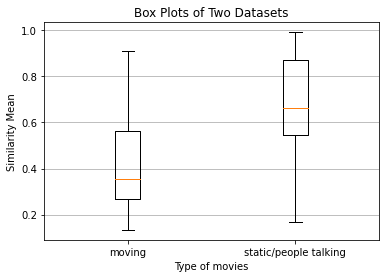

In [23]:
import matplotlib.pyplot as plt
data_m = [m[k] for k in m.keys()]
data_n = [n[k] for k in n.keys()]
data = [data_m, data_n]
plt.boxplot(data,labels=['moving video','static/people talking video'])

plt.xlabel('Type of movies')
plt.ylabel('Similarity Mean')
plt.title('Box Plots of Two Datasets')
plt.grid(axis='y')
plt.show()

In [52]:
plt.scatter(data_m, bins=20, color='blue', alpha=0.7, label='Data 1')

# Create a histogram for data2 (red bars)
plt.scatter(data_n, bins=20, color='red', alpha=0.7, label='Data 2')

TypeError: scatter() missing 1 required positional argument: 'y'

In [7]:
for k in m.keys():
    if isinstance(m[k], str):
        m[k] = eval(m[k])
m

{'8eBU4QfrFL4': 0.2627450064765896,
 '1-jnsbRQYCM': 0.26208635589803664,
 'V7xk-kgpZmk': 0.3558261743236537,
 'qB-E8q3yK4Q': 0.32733089724614794,
 'ke0YxzcZ1w4': 0.4549914748554496,
 'OGilPWdaikI': 0.21705565239359706,
 '9FSubSIXleo': 0.9099676085814716,
 'RHbDxf4EKb0': 0.4253808794266013,
 'jGuN68Z9rAY': 0.15433597491557513,
 'n1MIslYNju8': 0.6134641351345013,
 'McgjTFyCTfA': 0.13344042161190492,
 'qTPKGVrFtQU': 0.18724598751090854,
 'Q_EAYzJFt2g': 0.518258128156821,
 'NM08R4kWcB8': 0.27675932474311954,
 'kMsWyPjRUZE': 0.31417895739414325,
 'IsS_d1FUJRU': 0.7164702533538562,
 'Ac533ZkHD5I': 0.4265313987476557,
 '6-GlYzwQkt8': 0.6408029655628088,
 'i49TpqT2bps': 0.34942621317975764,
 'ibIYI4A_1PU': 0.5719245972595263,
 'nQRRtfv32Cs': 0.5541197916428751,
 'wdMEFFNou3Y': 0.21648792259457214,
 'jN1iAqW_SAY': 0.5764511052026678,
 'R2XlDqK6QYs': 0.7227266130453698,
 'Pp395_y5iAY': 0.2878323549453478,
 'XkPO0aGiwY8': 0.36189257984169004,
 'CiqD1W_xcs4': 0.27532993477606094}

In [12]:
n = {#'IJarJcOY8uU': 0.5416577065488487,
 'LN9RYIR2GyA': 0.6245125018169723,
 'zhL4N9uXQO4': 0.8639062871118905,
 '33te_Pqn9CY': 0.648065124574657,
 'O0U3soa2FY4': 0.8436315432143237,
 'Hv0lzJZkfqU': 0.6063747992040691,
 'XTaBAksP1d8': 0.4122338800326437,
 'vFmSrHcm1_0': 0.8908526789612835,
 'su7G18Flmpg': 0.9901220787098525,
 #'wzYeeEq_bpE': 0.5412414031902123,
 'ABdevFdahy4': 0.6613431464847749,
 'RBmeiMZQLsA': 0.9915925175788288,
 'fEMqCktQEJo': 0.8599246765363064,
 'H9jjNPfeWmA': 0.16595943083483156,
 '8LX4earN0gY': 0.43478139784307956,
 'obPT0w4LPow': 0.9002384893980774,
 'pSlCKuSSdkA': 0.5581156188899443,
 'nFMunlQ4ZrM': 0.5355585349572771,
 'S1-xgIAVK4s': 0.2832637194028228,
 #'TtA4Txii0us': 0.41027434155923603,
 'P5lDJYAsy_E': 0.878871902269137,
 'TtTsNNXrRU0': 0.8320166385714032}

In [258]:
json.dump(n, open('static.json', 'w'))

In [128]:
#his_similarity_vlist_static=[]

In [220]:
his_similarity_vlist_static.append(video_info)

In [222]:
len(his_similarity_vlist_static)

22

In [223]:
his_similarity_vlist_static

[{'vid: ': 'IJarJcOY8uU', 'difference mean: ': 0.5416577065488487},
 {'vid: ': 'LN9RYIR2GyA', 'difference mean: ': 0.6245125018169723},
 {'vid: ': 'zhL4N9uXQO4', 'difference mean: ': 0.8639062871118905},
 {'vid: ': '33te_Pqn9CY', 'difference mean: ': 0.648065124574657},
 {'vid: ': 'O0U3soa2FY4', 'difference mean: ': 0.8436315432143237},
 {'vid: ': 'Hv0lzJZkfqU', 'difference mean: ': 0.6063747992040691},
 {'vid: ': 'XTaBAksP1d8', 'difference mean: ': 0.4122338800326437},
 {'vid: ': 'vFmSrHcm1_0', 'difference mean: ': 0.8908526789612835},
 {'vid: ': 'su7G18Flmpg', 'difference mean: ': 0.9901220787098525},
 {'vid: ': 'wzYeeEq_bpE', 'difference mean: ': 0.5412414031902123},
 {'vid: ': 'ABdevFdahy4', 'difference mean: ': 0.6613431464847749},
 {'vid: ': 'fEMqCktQEJo', 'difference mean: ': 0.9915925175788288},
 {'vid: ': 'H9jjNPfeWmA', 'difference mean: ': 0.8599246765363064},
 {'vid: ': '8LX4earN0gY', 'difference mean: ': 0.16595943083483156},
 {'vid: ': 'obPT0w4LPow', 'difference mean: ': 0

In [218]:
len(v_list_static)

25

In [228]:
keys = []
val = []
for i in range(22):
    if i >= 21:
        keys.append(v_list_static[i+1])
        val.append(his_similarity_vlist_static[i]['difference mean: '])
    else:
        keys.append(v_list_static[i])
        val.append(his_similarity_vlist_static[i]['difference mean: '])
        

In [233]:
n = {}
for k, v in zip(keys, val):
    n[k] = v
n

{'IJarJcOY8uU': 0.5416577065488487,
 'LN9RYIR2GyA': 0.6245125018169723,
 'zhL4N9uXQO4': 0.8639062871118905,
 '33te_Pqn9CY': 0.648065124574657,
 'O0U3soa2FY4': 0.8436315432143237,
 'Hv0lzJZkfqU': 0.6063747992040691,
 'XTaBAksP1d8': 0.4122338800326437,
 'vFmSrHcm1_0': 0.8908526789612835,
 'su7G18Flmpg': 0.9901220787098525,
 'wzYeeEq_bpE': 0.5412414031902123,
 'ABdevFdahy4': 0.6613431464847749,
 'RBmeiMZQLsA': 0.9915925175788288,
 'fEMqCktQEJo': 0.8599246765363064,
 'H9jjNPfeWmA': 0.16595943083483156,
 '8LX4earN0gY': 0.43478139784307956,
 'obPT0w4LPow': 0.9002384893980774,
 'pSlCKuSSdkA': 0.5581156188899443,
 'nFMunlQ4ZrM': 0.5355585349572771,
 'S1-xgIAVK4s': 0.2832637194028228,
 'TtA4Txii0us': 0.41027434155923603,
 'P5lDJYAsy_E': 0.878871902269137,
 'TtTsNNXrRU0': 0.8320166385714032}

In [11]:
v_list_static=["IJarJcOY8uU","LN9RYIR2GyA","zhL4N9uXQO4","33te_Pqn9CY","O0U3soa2FY4","Hv0lzJZkfqU","XTaBAksP1d8","vFmSrHcm1_0","su7G18Flmpg","wzYeeEq_bpE","ABdevFdahy4","RBmeiMZQLsA","fEMqCktQEJo","H9jjNPfeWmA","8LX4earN0gY","obPT0w4LPow","pSlCKuSSdkA","nFMunlQ4ZrM","S1-xgIAVK4s","TtA4Txii0us","P5lDJYAsy_E","xbSp0TxZpM4","TtTsNNXrRU0","NQU7dxNJZEs","Vbia3YSI3pY"]

v_list_move = [
    "i49TpqT2bps",
    "ibIYI4A_1PU",
    "nQRRtfv32Cs",
    "wdMEFFNou3Y",
    "jN1iAqW_SAY",
    "R2XlDqK6QYs",
	"Pp395_y5iAY",
	"XkPO0aGiwY8",
	"CiqD1W_xcs4",
    "Xn_7rwAHpPs",
    "8eBU4QfrFL4",
    "1-jnsbRQYCM",
    "V7xk-kgpZmk",
    "qB-E8q3yK4Q",
    "ke0YxzcZ1w4",
    "OGilPWdaikI",
    "9FSubSIXleo",
    "RHbDxf4EKb0",
    "jGuN68Z9rAY",
    "n1MIslYNju8",
    "McgjTFyCTfA",
    "qTPKGVrFtQU",
    "Q_EAYzJFt2g",
    "NM08R4kWcB8",
    "kMsWyPjRUZE",
    "IsS_d1FUJRU",
    "Ac533ZkHD5I",
    "ZNSwYGkDtNY",
    "6-GlYzwQkt8"
  ]

v_list_static=["IJarJcOY8uU","LN9RYIR2GyA","zhL4N9uXQO4","33te_Pqn9CY","O0U3soa2FY4","Hv0lzJZkfqU","XTaBAksP1d8","vFmSrHcm1_0","su7G18Flmpg","wzYeeEq_bpE","ABdevFdahy4","RBmeiMZQLsA","fEMqCktQEJo","H9jjNPfeWmA","8LX4earN0gY","obPT0w4LPow","pSlCKuSSdkA","nFMunlQ4ZrM","S1-xgIAVK4s","TtA4Txii0us","P5lDJYAsy_E","xbSp0TxZpM4","TtTsNNXrRU0","NQU7dxNJZEs","Vbia3YSI3pY"]


In [106]:
value = []
vids = []
for di in his_similarity_vlist_02:
    value.append(di['difference mean: '])
for i in range(len(v_list_move)):
    if i > 9 and not i == 27:
        vids.append(v_list_move[i])

In [120]:
result = zip(vids, value)

In [121]:
m = {}

In [232]:
import json
json.dump(m, open('moved_video.json', 'w'))

In [122]:
for v, va in result:
    m[str(v)] = str(va)

8eBU4QfrFL4
1-jnsbRQYCM
V7xk-kgpZmk
qB-E8q3yK4Q
ke0YxzcZ1w4
OGilPWdaikI
9FSubSIXleo
RHbDxf4EKb0
jGuN68Z9rAY
n1MIslYNju8
McgjTFyCTfA
qTPKGVrFtQU
Q_EAYzJFt2g
NM08R4kWcB8
kMsWyPjRUZE
IsS_d1FUJRU
Ac533ZkHD5I
6-GlYzwQkt8


In [124]:
li = [{'vid: ': 'i49TpqT2bps', 'difference mean: ': 0.34942621317975764},
 {'vid: ': 'ibIYI4A_1PU', 'difference mean: ': 0.5719245972595263},
 {'vid: ': 'nQRRtfv32Cs', 'difference mean: ': 0.5541197916428751},
 {'vid: ': 'wdMEFFNou3Y', 'difference mean: ': 0.21648792259457214},
 {'vid: ': 'jN1iAqW_SAY', 'difference mean: ': 0.5764511052026678},
 {'vid: ': 'R2XlDqK6QYs', 'difference mean: ': 0.7227266130453698},
 {'vid: ': 'Pp395_y5iAY', 'difference mean: ': 0.2878323549453478},
 {'vid: ': 'XkPO0aGiwY8', 'difference mean: ': 0.36189257984169004},
 {'vid: ': 'CiqD1W_xcs4', 'difference mean: ': 0.27532993477606094}]

In [125]:
for l in li:
    m[l['vid: ']] = l['difference mean: ']

In [127]:
len(m.keys())

27

In [126]:
m

{'8eBU4QfrFL4': '0.2627450064765896',
 '1-jnsbRQYCM': '0.26208635589803664',
 'V7xk-kgpZmk': '0.3558261743236537',
 'qB-E8q3yK4Q': '0.32733089724614794',
 'ke0YxzcZ1w4': '0.4549914748554496',
 'OGilPWdaikI': '0.21705565239359706',
 '9FSubSIXleo': '0.9099676085814716',
 'RHbDxf4EKb0': '0.4253808794266013',
 'jGuN68Z9rAY': '0.15433597491557513',
 'n1MIslYNju8': '0.6134641351345013',
 'McgjTFyCTfA': '0.13344042161190492',
 'qTPKGVrFtQU': '0.18724598751090854',
 'Q_EAYzJFt2g': '0.518258128156821',
 'NM08R4kWcB8': '0.27675932474311954',
 'kMsWyPjRUZE': '0.31417895739414325',
 'IsS_d1FUJRU': '0.7164702533538562',
 'Ac533ZkHD5I': '0.4265313987476557',
 '6-GlYzwQkt8': '0.6408029655628088',
 'i49TpqT2bps': 0.34942621317975764,
 'ibIYI4A_1PU': 0.5719245972595263,
 'nQRRtfv32Cs': 0.5541197916428751,
 'wdMEFFNou3Y': 0.21648792259457214,
 'jN1iAqW_SAY': 0.5764511052026678,
 'R2XlDqK6QYs': 0.7227266130453698,
 'Pp395_y5iAY': 0.2878323549453478,
 'XkPO0aGiwY8': 0.36189257984169004,
 'CiqD1W_xcs4': 0.

In [ ]:
his_similarity_vlist_02

In [90]:
len(v_list_move)

29

In [ ]:
his_similarity_vlist_move

In [ ]:
his_similarity_vlist_static=get_allVideo_mean_differenceInlist_his(v_list_static)

In [ ]:
his_similarity_vlist_static